In [1]:
import os
import fitz
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Разбор PDF на изображение

In [2]:
def file_to_png(file_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Открываем PDF файл
    pdf_document = fitz.open(file_path)

    # Проходим по всем страницам PDF и сохраняем их в формате PNG
    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        image = page.get_pixmap()

        
        image.save(os.path.join(output_folder, f'img{page_number+1}.png'))


    # Закрываем PDF файл
    pdf_document.close()
    print('Done!')

In [3]:
# Функция очистки папки
def clear_folder(folder_path):
    # Проверка существования папки
    if os.path.exists(folder_path):
        # Перебор всех файлов в папке
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            # Удаление файла
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
    else:
        print(f'Папка {folder_path} не найдена')

### Удаление красного фона

In [3]:
file_to_png('input_pdf/KD3.pdf', 'KD3_img')

In [96]:
import cv2
import numpy as np

# Загрузка изображения
image = cv2.imread('KD3_img\img6.png')

# Конвертация изображения в HSV (Hue, Saturation, Value), чтобы упростить отделение красного цвета
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Определение диапазона красного цвета
# Эти значения могут потребовать настройки для конкретного оттенка красного цвета вашего фона
lower_red = np.array([0, 40, 50])
upper_red = np.array([10, 255, 255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)

lower_red = np.array([350, 50, 50])
upper_red = np.array([360, 255, 255])
mask2 = cv2.inRange(hsv, lower_red, upper_red)

# Объединение масок для красного цвета
mask = mask1 + mask2

# Инвертирование маски для получения обратной маски
mask_inv = cv2.bitwise_not(mask)

# Отделение красного фона от изображения
background = cv2.bitwise_and(image, image, mask=mask)

# Отделение содержимого анкеты от фона
foreground = cv2.bitwise_and(image, image, mask=mask_inv)

# Сохранение результата
cv2.imwrite('proc_img/anketa_no_red.jpg', foreground)

# Отображение изображения
cv2.imshow('Result', foreground)
cv2.waitKey(0)
cv2.destroyAllWindows()



#### Перевод изображения в HSV сохранение канала V

In [20]:
print('type: ', type(image))
print('shape: ', image.shape)

type:  <class 'numpy.ndarray'>
shape:  (792, 612, 3)


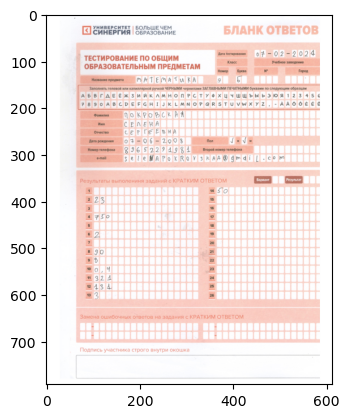

In [22]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [62]:
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# Извлечение канала V
v_channel = img_hsv[..., 2]

# Сохранение канала V в файл
cv2.imwrite('proc_img/v_channel.jpg', v_channel)

True

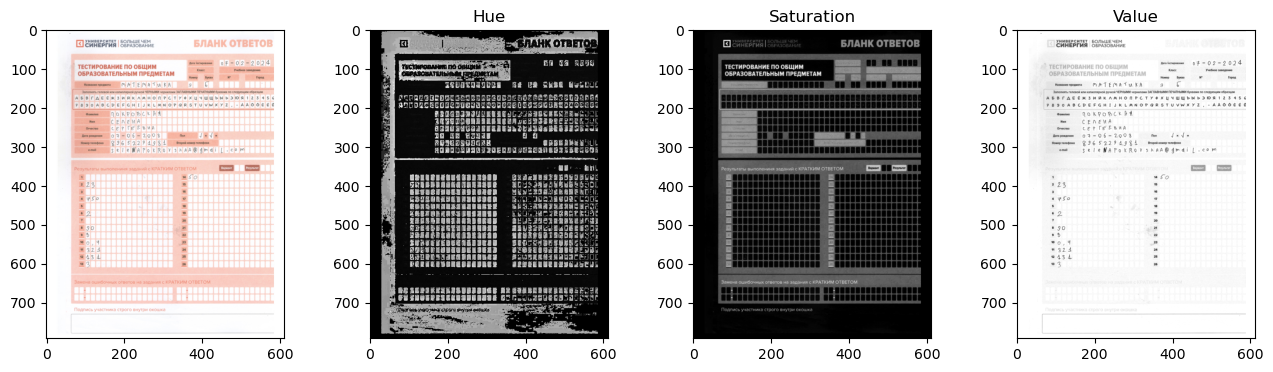

In [24]:
plt.figure(1, figsize = (16, 4))
plt.subplot(141)
plt.imshow(image[...,::-1])
plt.subplot(142)
plt.imshow(img_hsv[...,0], cmap='gray')
plt.title('Hue')
plt.subplot(143)
plt.imshow(img_hsv[...,1], cmap='gray')
plt.title('Saturation')
plt.subplot(144)
plt.imshow(img_hsv[...,2], cmap='gray')
plt.title('Value');

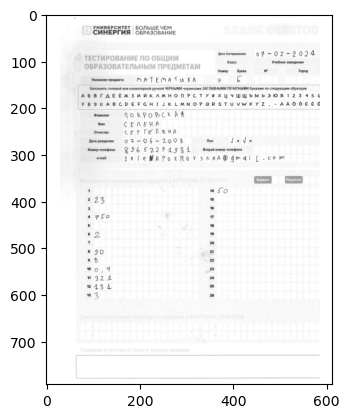

In [61]:
plt.imshow(img_hsv[...,2], cmap='gray')
# Сохранение изображения


### Определение типа анкеты

In [207]:
import cv2

def detect_rectangles(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Бинаризация изображения
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Нахождение контуров
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    rectangle_threshold = 400
    # Инициализация счетчика прямоугольников
    rectangle_count = 0

    for cnt in contours:
        # Приближение контуров к прямоугольной форме
        epsilon = 0.05 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # Если контур имеет 4 вершины, предполагаем, что это прямоугольник
        if len(approx) == 4:
            rectangle_count += 1

    # Проверка количества найденных прямоугольников
    if rectangle_count > rectangle_threshold:
        print("Анкета в клеточку")
    else:
        print("Анкета в линейку")
    
    return rectangle_count







In [221]:
# Пример использования функции
detect_rectangles('cropped_fragments/fragment_2986.jpg')


Анкета в линейку


138

In [205]:
# Пример использования функции
detect_rectangles('C:/Users/vpgusev/Documents/GitHub/Work_projects/Func_Y_OCR/output_images/img6.png')

Анкета в линейку


349

### Работа

In [5]:
clear_folder('b_w')
clear_folder('Ank_img')
clear_folder('check_box')
clear_folder('cropped_fragments')
clear_folder('preproc')
clear_folder('check_boxdetect')

Папка b_w не найдена
Папка check_box не найдена
Папка cropped_fragments не найдена


In [6]:
file_to_png('input_pdf/Ank_chbox.pdf', 'Ank_img')

Done!


In [7]:
from boxdetect import config
from boxdetect.pipelines import get_checkboxes

In [41]:

def box_detect(image_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cfg = config.PipelinesConfig()

    cfg.width_range = (25,87)
    cfg.height_range = (25,87)

    cfg.scaling_factors = [1.3]

    cfg.wh_ratio_range = (0.8, 1.2)


    cfg.group_size_range = (1, 1)

    #cfg.morph_kernels_type = 'rectangles'

    cfg.dilation_iterations = 0

    from boxdetect.pipelines import get_boxes

    rects, grouping_rects, image, output_image = get_boxes(image_path, cfg=cfg, plot=False)

    output_path = os.path.join(output_folder, f'check_box_{os.path.splitext(os.path.basename(image_path))[0]}.png')
                
                # Сохранение вырезанного фрагмента в файл
    cv2.imwrite(output_path, output_image)

    



In [42]:
clear_folder('check_boxdetect')

In [44]:
output_folder = "check_boxdetect"
for img in os.listdir("D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated"):
    image_path = os.path.join("D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated", img)

    box_detect(image_path, output_folder)

Processing file:  D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated\rotated_img1.jpg
Processing file:  D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated\rotated_img2.jpg
Processing file:  D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated\rotated_img3.jpg
Processing file:  D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated\rotated_img4.jpg
Processing file:  D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated\rotated_img5.jpg


Processing file:  D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated/rotated_img5.jpg
Output object type:  <class 'numpy.ndarray'>
Checkbox bounding rectangle (x,y,width,height):  (164, 952, 31, 31)
Result of `contains_pixels` for the checkbox:  False
Display the cropout of checkbox:


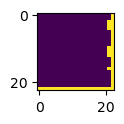

Checkbox bounding rectangle (x,y,width,height):  (604, 953, 30, 30)
Result of `contains_pixels` for the checkbox:  False
Display the cropout of checkbox:


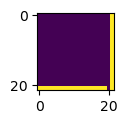

Checkbox bounding rectangle (x,y,width,height):  (1019, 951, 31, 31)
Result of `contains_pixels` for the checkbox:  False
Display the cropout of checkbox:


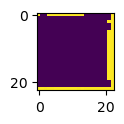

Checkbox bounding rectangle (x,y,width,height):  (597, 1984, 30, 33)
Result of `contains_pixels` for the checkbox:  True
Display the cropout of checkbox:


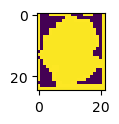

Checkbox bounding rectangle (x,y,width,height):  (1018, 1983, 29, 32)
Result of `contains_pixels` for the checkbox:  False
Display the cropout of checkbox:


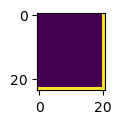

Checkbox bounding rectangle (x,y,width,height):  (153, 2061, 29, 34)
Result of `contains_pixels` for the checkbox:  False
Display the cropout of checkbox:


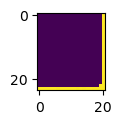

Checkbox bounding rectangle (x,y,width,height):  (597, 2059, 30, 32)
Result of `contains_pixels` for the checkbox:  False
Display the cropout of checkbox:


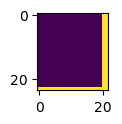

Checkbox bounding rectangle (x,y,width,height):  (1018, 2060, 29, 33)
Result of `contains_pixels` for the checkbox:  True
Display the cropout of checkbox:


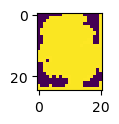

In [49]:
image_path = "D:/GITHUB/Work_projects/Func_Y_OCR/proc/rotated/rotated_img5.jpg"
cfg = config.PipelinesConfig()

cfg.width_range = (25,87)
cfg.height_range = (25,87)

cfg.scaling_factors = [1.3]

cfg.wh_ratio_range = (0.8, 1.2)


cfg.group_size_range = (1, 1)

cfg.dilation_iterations = 0

checkboxes = get_checkboxes(
        image_path, cfg=cfg, px_threshold=0.2, plot=False, verbose=False)

print("Output object type: ", type(checkboxes))
for checkbox in checkboxes:
    print("Checkbox bounding rectangle (x,y,width,height): ", checkbox[0])
    print("Result of `contains_pixels` for the checkbox: ", checkbox[1])
    print("Display the cropout of checkbox:")
    plt.figure(figsize=(1,1))
    plt.imshow(checkbox[2])
    plt.show()

In [108]:
image_path = 'Ank_img\img10.png'
image = cv2.imread(image_path)
height, width = image.shape[:2]
print(height, width)

2096 3036


In [25]:
# Функция поиска чек боксов и разделения их на заполненные и незаполненные
def checkbox_detect(image_path):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    cfg = config.PipelinesConfig()

    cfg.width_range = (30,87)
    cfg.height_range = (30,87)

    cfg.scaling_factors = [1.3]

    cfg.wh_ratio_range = (0.8, 1.2)


    cfg.group_size_range = (1, 1)

    cfg.dilation_iterations = 0

    checkboxes = get_checkboxes(
        image_path, cfg=cfg, px_threshold=0.1, plot=False, verbose=False)
    
    # определение конца сегмента для распознанного текста путем сравнения координат
    # чек боксов, стоящих на одной линии
    checkbox_coord = []

    for el in checkboxes:
        found = False
        for i in checkboxes:
            if el[0] != i[0]:
                if abs(int(el[0][1])/int(height)*100-int(i[0][1])/int(height)*100)<=1 and\
                int(el[0][0]) < int(i[0][0]):
                    coord = el[0] +(int(i[0][0]), int(height))
                    el = np.array([coord, el[1], el[2]], dtype=object)
                    checkbox_coord.append(el)
                    found = True
                    break
        if not found:
            coord = el[0] +(int(width), int(height))
            el = np.array([coord, el[1], el[2]], dtype=object)
            checkbox_coord.append(el)
                    
    # Разделение списков чек боксов на заполненные и незаполненные
    boxes = []
    checked_box = []

    for checkbox in checkbox_coord:
        boxes.append(checkbox[0])
        
    found = False
    for checkbox in checkbox_coord:
        if checkbox[1]:
            checked_box.append(checkbox[0])
            found = True
    if not found:
       checked_box.append(())
        
    return boxes, checked_box
        

In [26]:
boxes_list = []
checkbox_list = []
for img in os.listdir('Ank_img'):
    image_path = os.path.join('Ank_img', img)  
    boxes, checked_box = checkbox_detect(image_path)
    boxes_list.append(boxes)
    checkbox_list.append(checked_box)

Processing file:  Ank_img\img1.png
Processing file:  Ank_img\img2.png
Processing file:  Ank_img\img3.png
Processing file:  Ank_img\img4.png
Processing file:  Ank_img\img5.png


In [27]:
checkbox_list[1]


[(184, 967, 31, 31, 635, 2338),
 (1059, 971, 31, 32, 1656, 2338),
 (636, 1047, 31, 31, 1059, 2338)]

In [195]:
print(type(boxes))

<class 'list'>


In [28]:
boxes_list[1]

[(184, 967, 31, 31, 635, 2338),
 (635, 971, 31, 31, 1059, 2338),
 (1059, 971, 31, 32, 1656, 2338),
 (185, 1038, 31, 32, 636, 2338),
 (636, 1047, 31, 31, 1059, 2338),
 (1059, 1046, 31, 32, 1656, 2338)]